<a href="https://colab.research.google.com/github/espartaca75-prog/Optmizacion_dinamica_discreta/blob/main/COD_programaci%C3%B3n_din%C3%A1mica_Ejemplo_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ejemplo 2

---



In [1]:
import numpy as np
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt

In [2]:
# --- 1. CONFIGURACIÓN INICIAL DEL PROBLEMA ---
T = 10           # Horizonte temporal
k0 = 1.0        # Stock inicial

In [3]:
# --- 2. INDUCCIÓN HACIA ATRÁS ---

# Definimos la función que representa Vt(kt).
# En el periodo T, la función de valor es ln(kT)
valor_funciones = {T: lambda k: np.log(k)}
# Almacenamos las políticas encontradas numéricamente para cada t
politicas_num = {}

print("Iniciando Inducción Hacia Atrás...")

for t in range(T-1, -1, -1):
    # Definimos la Ecuación de Bellman para el periodo t:
    # Vt(kt) = max_{ct >= 0} [ f(kt,ct) + Vt+1( g(kt,ct) ) ]

    def objetivo_negativo(c, k_actual, t_idx):
        # f(kt, ct) = -2/3 * ct * kt
        recompensa_inmediata = -(2/3) * c * k_actual
        # k_{t+1} = k * (1 + c*k)
        k_siguiente = k_actual * (1 + c * k_actual)

        # Valor futuro (proviene de la etapa anterior de la inducción)
        valor_futuro = valor_funciones[t_idx + 1](k_siguiente)

        # Minimizamos el negativo para maximizar el valor
        return -(recompensa_inmediata + valor_futuro)

    # Optimizando para un k genérico.
    k_test = 1.0
    res = minimize_scalar(objetivo_negativo, args=(k_test, t), bounds=(0, 10), method='bounded')

    # Guardamos la regla descubierta: ct* en relación a kt
    # El optimizador nos dice que para k=1, c es res.x.
    # Dado que ct* = 1/(2kt), guardamos la relación numérica hallada.
    ratio_hallado = res.x * k_test
    politicas_num[t] = lambda k, r=ratio_hallado: r / k

    # Actualizamos la función de valor para la siguiente etapa
    def vt_actual(k, t_idx=t):
        c_opt = politicas_num[t_idx](k)
        return -(objetivo_negativo(c_opt, k, t_idx))

    valor_funciones[t] = vt_actual
    print(f"Etapa t={t}: Optimizador encontró que ct* ≈ {ratio_hallado:.2f}/kt")

Iniciando Inducción Hacia Atrás...
Etapa t=9: Optimizador encontró que ct* ≈ 0.50/kt
Etapa t=8: Optimizador encontró que ct* ≈ 0.50/kt
Etapa t=7: Optimizador encontró que ct* ≈ 0.50/kt
Etapa t=6: Optimizador encontró que ct* ≈ 0.50/kt
Etapa t=5: Optimizador encontró que ct* ≈ 0.50/kt
Etapa t=4: Optimizador encontró que ct* ≈ 0.50/kt
Etapa t=3: Optimizador encontró que ct* ≈ 0.50/kt
Etapa t=2: Optimizador encontró que ct* ≈ 0.50/kt
Etapa t=1: Optimizador encontró que ct* ≈ 0.50/kt
Etapa t=0: Optimizador encontró que ct* ≈ 0.50/kt


In [4]:
# --- 3. RECONSTRUCCIÓN DE LA TRAYECTORIA ---
k_trayectoria = [k0]
c_trayectoria = []

for t in range(T):
    k_t = k_trayectoria[-1]
    c_t = politicas_num[t](k_t)
    c_trayectoria.append(c_t)

    # Evolución del estado: k_{t+1} = k_t * (1 + c_t * k_t)
    k_next = k_t * (1 + c_t * k_t)
    k_trayectoria.append(k_next)

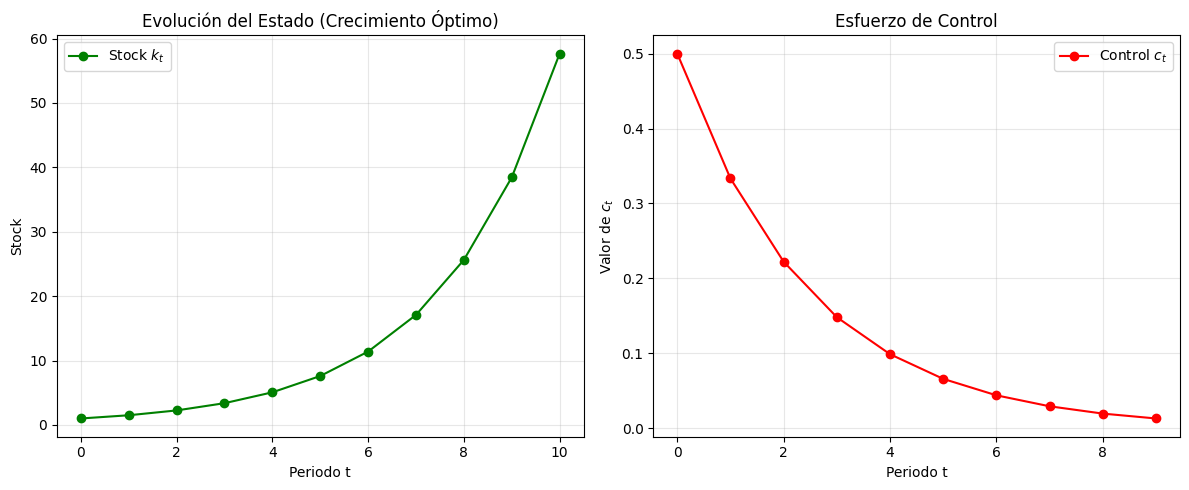

In [5]:
# --- 4. VISUALIZACIÓN ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_trayectoria, 'go-', label='Stock $k_t$')
plt.title('Evolución del Estado (Crecimiento Óptimo)')
plt.xlabel('Periodo t')
plt.ylabel('Stock')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(c_trayectoria, 'ro-', label='Control $c_t$')
plt.title('Esfuerzo de Control')
plt.xlabel('Periodo t')
plt.ylabel('Valor de $c_t$')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

In [6]:
# --- 5. ARMAMOS UNA LISTA CON LOS RESULTADOS ---
import pandas as pd

# Creamos una lista de periodos
periodos = list(range(T + 1))

# Preparamos la columna de control, añadiendo 'N/A' para el último periodo
c_control_df = c_trayectoria + ['N/A']

# Creamos el DataFrame
df_resultados = pd.DataFrame({
    'Periodo': periodos,
    'Control (ct_t)': c_control_df,
    'Stock (kt_t)': k_trayectoria
})

df_resultados

,Periodo,Control (ct_t),Stock (kt_t)
0,0,0.499999,1.000000
1,1,0.333333,1.499999
2,2,0.222222,2.249996
3,3,0.148148,3.374991
4,4,0.098766,5.062482
5,5,0.065844,7.593716
6,6,0.043896,11.390563
7,7,0.029264,17.085829
8,8,0.019509,25.628720
9,9,0.013006,38.443046


In [7]:
# Verificación de la tasa de crecimiento por período
# La tasa de crecimiento para el período t es x_{t+1} / x_t
# Si la política es ct* = 1/(2kt), entonces k_{t+1} = k_t * (1 + 1/2) = 1.5 * k_t
# Por lo tanto, la tasa de crecimiento constante esperada es 1.5
crecimiento_por_periodo = [k_trayectoria[i+1] / k_trayectoria[i] for i in range(T)]

print("Tasas de crecimiento k(t+1)/k(t) halladas por período:")
for t_idx, rate in enumerate(crecimiento_por_periodo):
    print(f"  Periodo {t_idx} (k_{t_idx+1}/k_{t_idx}): {rate:.4f}")



Tasas de crecimiento k(t+1)/k(t) halladas por período:
  Periodo 0 (k_1/k_0): 1.5000
  Periodo 1 (k_2/k_1): 1.5000
  Periodo 2 (k_3/k_2): 1.5000
  Periodo 3 (k_4/k_3): 1.5000
  Periodo 4 (k_5/k_4): 1.5000
  Periodo 5 (k_6/k_5): 1.5000
  Periodo 6 (k_7/k_6): 1.5000
  Periodo 7 (k_8/k_7): 1.5000
  Periodo 8 (k_9/k_8): 1.5000
  Periodo 9 (k_10/k_9): 1.5000
